## S8 - Group Normalization

#### Target:
    No of parameters should be less than 50k.
    Accuracy of model should be between 70 and 94 which should be achieved in 20 epochs.

#### Result:
    No of parameters of model: 18212
    Best Test Accuracy: 68.3% ( 18th epoch)

#### Analysis:

    Model didn't overfit in initial epochs but it started overfitting in later epochs.
    I have taken same architecture used for Layer normalization and replaced layers with group normalization.
    As part of this network, I see that group normalization added less number of parameters when compared to Layer normalization.
    I see that this GN neural network can be trained few epochs / additional kernels can be added ( capacity can be increased) to gain more deeper patterns which would have helped model to identify differences between (airplane and bird ) and ( horse and deer ).



### Import heavenly gods / libraries

In [ ]:
from __future__ import print_function
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                        transforms.ToTensor(),
                                       transforms.Normalize((0.49139968, 0.48215827 ,0.44653124,), (0.24703233,0.24348505,0.26158768,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.49139968, 0.48215827 ,0.44653124,), (0.24703233,0.24348505,0.26158768,))
                                       ])

## Load CIFAR10 dataset

In [ ]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:02<00:00, 77521325.73it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Dataloader Arguments and Train/Test Dataloaders

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Data Statistics

* Compute mean , standard deviation, variance of training data
* Visualizing images in a batch

[Train]
 - Numpy Shape: (50000, 32, 32, 3)
 - Tensor Shape: torch.Size([50000, 32, 32, 3])
 - min: tensor(0.)
 - max: tensor(255.)
 - mean: tensor(120.7076)
 - std: tensor(64.1501)
 - var: tensor(4115.2324)


torch.Size([3, 32, 32])
torch.Size([64])


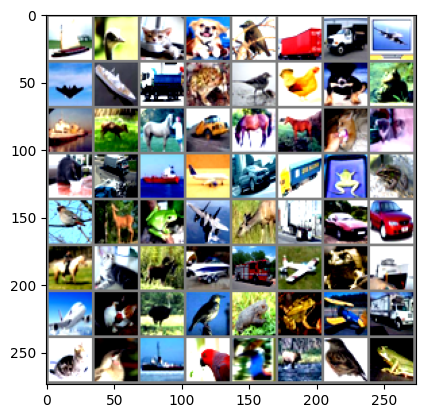

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.data
train_data_tensor = torch.Tensor(train_data)

print('[Train]')
print(' - Numpy Shape:', train.data.shape)
print(' - Tensor Shape:', train_data_tensor.size())
print(' - min:', torch.min(train_data_tensor))
print(' - max:', torch.max(train_data_tensor))
print(' - mean:', torch.mean(train_data_tensor))
print(' - std:', torch.std(train_data_tensor))
print(' - var:', torch.var(train_data_tensor))

def imshow(img, labels):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(labels)
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images[0].shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

imshow(make_grid(images), "")


# Define model for group normalization

C1 C2 c3 P1 C4 C5 C6 c7 P2 C8 C9 C10 GAP c11

In [ ]:
from model import Model_6

## model summary

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model_nn = Model_6().to(device)
summary(model_nn, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 30, 30]             324
         GroupNorm-2           [-1, 12, 30, 30]              24
              ReLU-3           [-1, 12, 30, 30]               0
           Dropout-4           [-1, 12, 30, 30]               0
            Conv2d-5           [-1, 24, 28, 28]           2,592
              ReLU-6           [-1, 24, 28, 28]               0
           Dropout-7           [-1, 24, 28, 28]               0
            Conv2d-8           [-1, 10, 28, 28]             240
              ReLU-9           [-1, 10, 28, 28]               0
          Dropout-10           [-1, 10, 28, 28]               0
        MaxPool2d-11           [-1, 10, 14, 14]               0
           Conv2d-12           [-1, 16, 12, 12]           1,440
        GroupNorm-13           [-1, 16, 12, 12]              32
             ReLU-14           [-1

### Functions to train and test the data

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))
    return test_loss

* Specified LR Scheduler ( ReduceLROnPlateau ).
* Training data for 20 epochs
* Using SGD as optimizer

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
model_nn =  Model_6().to(device)
optimizer = optim.SGD(model_nn.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, threshold=0.0001, threshold_mode='rel')
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model_nn, device, train_loader, optimizer, epoch)
    test_loss = test(model_nn, device, test_loader)
    scheduler.step(test_loss)
    print("LR: ", scheduler.get_last_lr())

EPOCH: 0


  0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=2.0003697872161865 Batch_id=781 Accuracy=25.60: 100%|██████████| 782/782 [00:20<00:00, 37.95it/s]



Test set: Average loss: 1.7709, Accuracy: 3204/10000 (32.04%)

LR:  [0.01]
EPOCH: 1


Loss=1.1677765846252441 Batch_id=781 Accuracy=39.06: 100%|██████████| 782/782 [00:21<00:00, 36.59it/s]



Test set: Average loss: 1.4952, Accuracy: 4448/10000 (44.48%)

LR:  [0.01]
EPOCH: 2


Loss=1.0057477951049805 Batch_id=781 Accuracy=48.05: 100%|██████████| 782/782 [00:21<00:00, 35.73it/s]



Test set: Average loss: 1.5205, Accuracy: 4507/10000 (45.07%)

LR:  [0.01]
EPOCH: 3


Loss=1.526913046836853 Batch_id=781 Accuracy=52.52: 100%|██████████| 782/782 [00:22<00:00, 34.64it/s]



Test set: Average loss: 1.2678, Accuracy: 5401/10000 (54.01%)

LR:  [0.01]
EPOCH: 4


Loss=1.063452124595642 Batch_id=781 Accuracy=55.10: 100%|██████████| 782/782 [00:23<00:00, 33.94it/s]



Test set: Average loss: 1.2254, Accuracy: 5645/10000 (56.45%)

LR:  [0.01]
EPOCH: 5


Loss=0.8294435143470764 Batch_id=781 Accuracy=57.04: 100%|██████████| 782/782 [00:20<00:00, 37.98it/s]



Test set: Average loss: 1.1773, Accuracy: 5794/10000 (57.94%)

LR:  [0.01]
EPOCH: 6


Loss=1.0149439573287964 Batch_id=781 Accuracy=58.65: 100%|██████████| 782/782 [00:20<00:00, 38.08it/s]



Test set: Average loss: 1.1217, Accuracy: 5994/10000 (59.94%)

LR:  [0.01]
EPOCH: 7


Loss=0.9751816391944885 Batch_id=781 Accuracy=60.02: 100%|██████████| 782/782 [00:20<00:00, 38.67it/s]



Test set: Average loss: 1.1195, Accuracy: 6051/10000 (60.51%)

LR:  [0.01]
EPOCH: 8


Loss=1.2893670797348022 Batch_id=781 Accuracy=61.28: 100%|██████████| 782/782 [00:21<00:00, 36.23it/s]



Test set: Average loss: 1.0379, Accuracy: 6269/10000 (62.69%)

LR:  [0.01]
EPOCH: 9


Loss=0.6696709990501404 Batch_id=781 Accuracy=61.98: 100%|██████████| 782/782 [00:21<00:00, 36.97it/s]



Test set: Average loss: 1.0120, Accuracy: 6310/10000 (63.10%)

LR:  [0.01]
EPOCH: 10


Loss=0.7291878461837769 Batch_id=781 Accuracy=63.07: 100%|██████████| 782/782 [00:21<00:00, 37.07it/s]



Test set: Average loss: 1.0747, Accuracy: 6184/10000 (61.84%)

LR:  [0.01]
EPOCH: 11


Loss=0.9186356663703918 Batch_id=781 Accuracy=63.35: 100%|██████████| 782/782 [00:20<00:00, 38.56it/s]



Test set: Average loss: 1.0418, Accuracy: 6312/10000 (63.12%)

LR:  [0.01]
EPOCH: 12


Loss=0.9354825019836426 Batch_id=781 Accuracy=64.25: 100%|██████████| 782/782 [00:20<00:00, 38.69it/s]



Test set: Average loss: 1.0132, Accuracy: 6436/10000 (64.36%)

LR:  [0.001]
EPOCH: 13


Loss=0.48386916518211365 Batch_id=781 Accuracy=67.56: 100%|██████████| 782/782 [00:20<00:00, 37.38it/s]



Test set: Average loss: 0.9202, Accuracy: 6711/10000 (67.11%)

LR:  [0.001]
EPOCH: 14


Loss=0.9825921058654785 Batch_id=781 Accuracy=68.23: 100%|██████████| 782/782 [00:21<00:00, 36.29it/s]



Test set: Average loss: 0.9132, Accuracy: 6781/10000 (67.81%)

LR:  [0.001]
EPOCH: 15


Loss=0.7384094595909119 Batch_id=781 Accuracy=68.32: 100%|██████████| 782/782 [00:21<00:00, 36.38it/s]



Test set: Average loss: 0.9069, Accuracy: 6777/10000 (67.77%)

LR:  [0.001]
EPOCH: 16


Loss=1.0175789594650269 Batch_id=781 Accuracy=68.58: 100%|██████████| 782/782 [00:21<00:00, 37.22it/s]



Test set: Average loss: 0.8975, Accuracy: 6804/10000 (68.04%)

LR:  [0.001]
EPOCH: 17


Loss=0.9720621705055237 Batch_id=781 Accuracy=68.68: 100%|██████████| 782/782 [00:20<00:00, 38.13it/s]



Test set: Average loss: 0.8965, Accuracy: 6830/10000 (68.30%)

LR:  [0.001]
EPOCH: 18


Loss=0.7549818158149719 Batch_id=781 Accuracy=68.84: 100%|██████████| 782/782 [00:19<00:00, 39.61it/s]



Test set: Average loss: 0.9043, Accuracy: 6780/10000 (67.80%)

LR:  [0.001]
EPOCH: 19


Loss=0.7796198725700378 Batch_id=781 Accuracy=68.92: 100%|██████████| 782/782 [00:20<00:00, 37.68it/s]



Test set: Average loss: 0.8981, Accuracy: 6807/10000 (68.07%)

LR:  [0.001]


### Plotted graph for training loss, testing loss, training and testing accuracy

Text(0.5, 1.0, 'Test Accuracy')

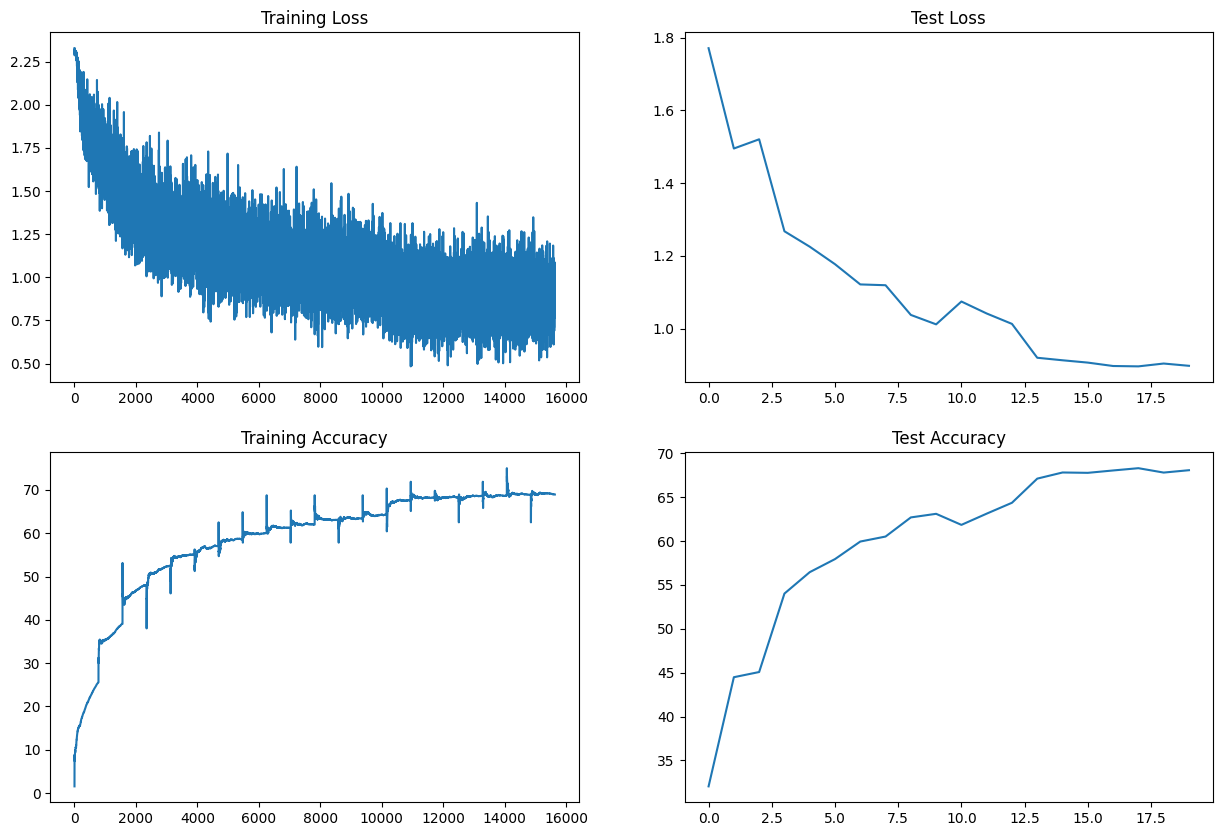

In [ ]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

### Below code is written to find the misclassified images , labels and their correct labels.

In [ ]:
# get mismatched images
model_nn.eval()
misclassified_images = []
misclassified_image_labels = []
correct_image_labels = []
class_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model_nn(data)
        # if (not pred.eq(target.view_as(pred))[0]):
        #   misclassified_images.append([data, target])
        pred = output.argmax(dim=1, keepdim=True)
        pred_classes = pred.squeeze().tolist()
        target_classes = target.view_as(pred).squeeze().tolist()
        for index in range(len(pred_classes)):
          if (pred_classes[index] != target_classes[index]):
            misclassified_images.append(data[index].cpu())
            misclassified_image_labels.append(class_labels[pred_classes[index]])
            correct_image_labels.append(class_labels[target_classes[index]])





### Obtain first 10 misclassified images and their coreesponding ground truth ( actual values) and predicted values

In [ ]:
first_ten_misclassified_images = misclassified_images[0:10]
first_ten_misclassified_labels = misclassified_image_labels[0:10]
first_ten_correct_labels = correct_image_labels[0:10]

In [ ]:
grid_image = make_grid(first_ten_misclassified_images, nrow=5, normalize=True)

In [ ]:
grid_image.shape

torch.Size([3, 70, 172])

In [ ]:
misclassified_dict= {}
for index in range(0, len(first_ten_correct_labels)):
  misclassified_dict["GT." + str(index) + ": " + first_ten_correct_labels[index]] = "Pred: " + first_ten_misclassified_labels[index]

In [ ]:
misclassified_dict

{'GT.0: automobile': 'Pred: cat',
 'GT.1: cat': 'Pred: bird',
 'GT.2: deer': 'Pred: dog',
 'GT.3: cat': 'Pred: ship',
 'GT.4: cat': 'Pred: dog',
 'GT.5: bird': 'Pred: cat',
 'GT.6: horse': 'Pred: deer',
 'GT.7: frog': 'Pred: cat',
 'GT.8: bird': 'Pred: airplane',
 'GT.9: airplane': 'Pred: truck'}

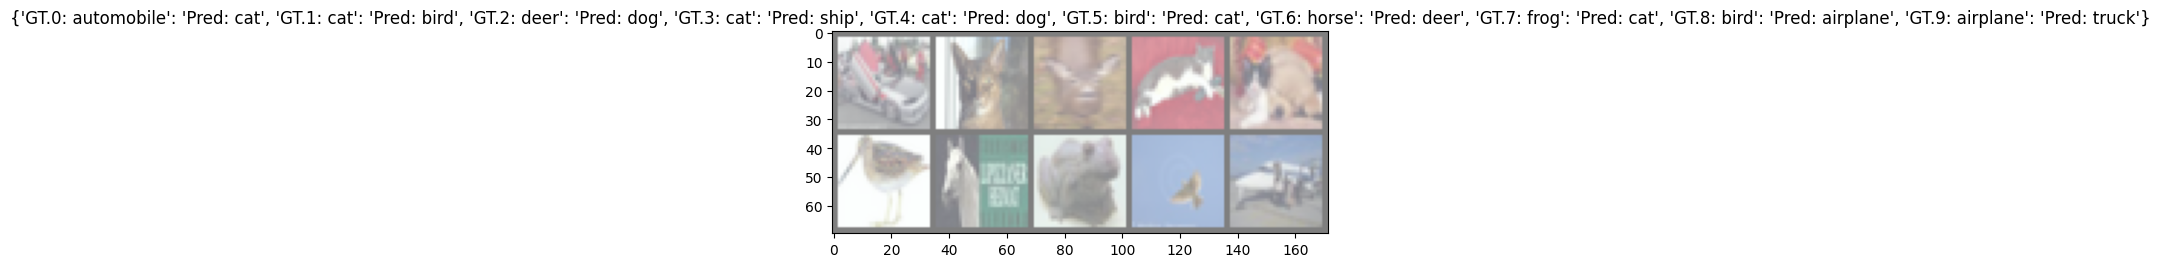

In [ ]:
imshow(grid_image, misclassified_dict)